## Setup and Imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime
from PIL import Image
import pandas as pd
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Import custom models
from models import InceptionModel, FaceNetModel

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Dataset Information

In [29]:
# Load dataset information
crop_path = Path('./datahub/crop')

# Load from 3 folders: real, fake, fake_45
real_folder = crop_path / 'real'
fake_folder = crop_path / 'fake'
fake_45_folder = crop_path / 'fake_45'

# Count images
real_images = sorted(list(real_folder.glob('*.jpg')) + list(real_folder.glob('*.png')))
fake_images = sorted(list(fake_folder.glob('*.jpg')) + list(fake_folder.glob('*.png')))
fake_45_images = sorted(list(fake_45_folder.glob('*.jpg')) + list(fake_45_folder.glob('*.png')))

# Extract IDs from filenames (e.g., "real_10.jpg" -> "10")
def extract_id(filename):
    """Extract ID from filename like 'real_10.jpg' or 'fake_45_2.jpg'"""
    name = filename.split('.')[0]  # Get filename without extension
    # Extract the last number part
    parts = name.split('_')
    return parts[-1]  # Last part is the ID

real_ids = sorted(set([extract_id(img.name) for img in real_images]))

dataset_info = {
    'real_images': len(real_images),
    'fake_images': len(fake_images),
    'fake_45_images': len(fake_45_images),
    'total_images': len(real_images) + len(fake_images) + len(fake_45_images),
    'total_ids': len(real_ids),
    'ids': real_ids
}

# Display information
print("="*80)
print("DATASET INFORMATION")
print("="*80)
print(f"Total IDs: {dataset_info['total_ids']}")
print(f"IDs: {', '.join(dataset_info['ids'])}")
print(f"\nImage Distribution:")
print(f"  Real images:    {dataset_info['real_images']}")
print(f"  Fake images:    {dataset_info['fake_images']}")
print(f"  Fake 45° images: {dataset_info['fake_45_images']}")
print(f"  Total images:   {dataset_info['total_images']}")

# Create DataFrame for visualization
df_dataset = pd.DataFrame([
    {'Category': 'Real', 'Count': dataset_info['real_images']},
    {'Category': 'Fake', 'Count': dataset_info['fake_images']},
    {'Category': 'Fake 45°', 'Count': dataset_info['fake_45_images']}
])

print("\n" + df_dataset.to_string(index=False))


DATASET INFORMATION
Total IDs: 10
IDs: 10, 14, 15, 2, 24, 26, 29, 3, 4, 5

Image Distribution:
  Real images:    10
  Fake images:    10
  Fake 45° images: 10
  Total images:   30

Category  Count
    Real     10
    Fake     10
Fake 45°     10


## 2. Load Images by Category

In [30]:
def load_images_with_labels(crop_path):
    """
    Load all images from real, fake, fake_45 folders with proper labels
    
    Returns:
        real_images: List of real image paths
        fake_images: List of fake image paths
        fake_45_images: List of fake_45 image paths
        id_mapping: Dictionary mapping ID to corresponding images
    """
    crop_path = Path(crop_path)
    
    real_folder = crop_path / 'real'
    fake_folder = crop_path / 'fake'
    fake_45_folder = crop_path / 'fake_45'
    
    # Load all images
    real_images = sorted(list(real_folder.glob('*.jpg')) + list(real_folder.glob('*.png')))
    fake_images = sorted(list(fake_folder.glob('*.jpg')) + list(fake_folder.glob('*.png')))
    fake_45_images = sorted(list(fake_45_folder.glob('*.jpg')) + list(fake_45_folder.glob('*.png')))
    
    # Extract ID from filename
    def extract_id(filename):
        """Extract ID from filename like 'real_10.jpg' or 'fake_2.jpg'"""
        name = filename.split('.')[0]  # Get filename without extension
        parts = name.split('_')
        return parts[-1]
    
    # Create ID mapping
    id_mapping = {}
    for real_img in real_images:
        id_val = extract_id(real_img.name)
        if id_val not in id_mapping:
            id_mapping[id_val] = {'real': None, 'fake': None, 'fake_45': None}
        id_mapping[id_val]['real'] = real_img
    
    for fake_img in fake_images:
        id_val = extract_id(fake_img.name)
        if id_val in id_mapping:
            id_mapping[id_val]['fake'] = fake_img
    
    for fake_45_img in fake_45_images:
        id_val = extract_id(fake_45_img.name)
        if id_val in id_mapping:
            id_mapping[id_val]['fake_45'] = fake_45_img
    
    return real_images, fake_images, fake_45_images, id_mapping

# Load data
real_images, fake_images, fake_45_images, id_mapping = load_images_with_labels(crop_path)

print(f"✓ Loaded images successfully:")
print(f"  Real: {len(real_images)} images")
print(f"  Fake: {len(fake_images)} images")
print(f"  Fake 45°: {len(fake_45_images)} images")
print(f"  IDs: {sorted(id_mapping.keys())}")


✓ Loaded images successfully:
  Real: 10 images
  Fake: 10 images
  Fake 45°: 10 images
  IDs: ['10', '14', '15', '2', '24', '26', '29', '3', '4', '5']


## 3. Initialize Three Models

In [31]:
print("Initializing models...\n")

# Model 1: InceptionV3
print("[1/3] Loading InceptionV3...")
model_inceptionv3 = InceptionModel(device='auto', image_size=1024)
print("✓ InceptionV3 loaded\n")

# Model 2: ResNet50 (FaceNet fallback)
print("[2/3] Loading ResNet50...")
model_resnet50 = FaceNetModel(device='auto', use_facenet=False)
print("✓ ResNet50 loaded\n")

# Model 3: FaceNet InceptionResnetV1
print("[3/3] Loading FaceNet InceptionResnetV1...")
model_facenet = FaceNetModel(device='auto', use_facenet=True)
print("✓ FaceNet InceptionResnetV1 loaded\n")

models = {
    'InceptionV3': model_inceptionv3,
    'ResNet50': model_resnet50,
    'FaceNet-InceptionResnetV1': model_facenet
}

print(f"✓ All {len(models)} models initialized successfully")

Initializing models...

[1/3] Loading InceptionV3...
Loading InceptionV3 model...
InceptionV3 loaded on cuda
✓ InceptionV3 loaded

[2/3] Loading ResNet50...
Loading ResNet50 model...
InceptionV3 loaded on cuda
✓ InceptionV3 loaded

[2/3] Loading ResNet50...
Loading ResNet50 model...
ResNet50 loaded on cuda
✓ ResNet50 loaded

[3/3] Loading FaceNet InceptionResnetV1...
Loading FaceNet (InceptionResnetV1) model...
ResNet50 loaded on cuda
✓ ResNet50 loaded

[3/3] Loading FaceNet InceptionResnetV1...
Loading FaceNet (InceptionResnetV1) model...
FaceNet loaded on cuda
✓ FaceNet InceptionResnetV1 loaded

✓ All 3 models initialized successfully
FaceNet loaded on cuda
✓ FaceNet InceptionResnetV1 loaded

✓ All 3 models initialized successfully


## 4. Extract Embeddings for All Models

In [32]:
def extract_embeddings(model, image_paths, model_name):
    """
    Extract embeddings for all images using given model
    """
    print(f"\nExtracting embeddings with {model_name}...")
    embeddings = []
    
    for i, img_path in enumerate(image_paths):
        try:
            # Extract embedding
            preprocessed = model.preprocess(img_path)
            features = model.inference(preprocessed)
            embedding = model.postprocess(features, output_type='embedding')
            embeddings.append(embedding[0])
            
            if (i + 1) % 10 == 0:
                print(f"  Processed {i + 1}/{len(image_paths)} images")
                
        except Exception as e:
            print(f"  ✗ Error processing {img_path}: {e}")
            # Use zero embedding as fallback
            if embeddings:
                embeddings.append(np.zeros_like(embeddings[0]))
            else:
                embeddings.append(np.zeros(512))  # Default size
    
    embeddings = np.array(embeddings)
    print(f"✓ Extracted {len(embeddings)} embeddings, shape: {embeddings.shape}")
    
    return embeddings

# Extract embeddings for all models and all categories
print("="*80)
print("EMBEDDING EXTRACTION")
print("="*80)

all_embeddings = {}

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Model: {model_name}")
    print(f"{'='*80}")
    
    # Extract for each category
    real_embs = extract_embeddings(model, real_images, f"{model_name} (Real)")
    fake_embs = extract_embeddings(model, fake_images, f"{model_name} (Fake)")
    fake_45_embs = extract_embeddings(model, fake_45_images, f"{model_name} (Fake 45°)")
    
    all_embeddings[model_name] = {
        'real': real_embs,
        'fake': fake_embs,
        'fake_45': fake_45_embs
    }

print("\n" + "="*80)
print("✓ All embeddings extracted successfully")
print("="*80)


EMBEDDING EXTRACTION

Model: InceptionV3

Extracting embeddings with InceptionV3 (Real)...
  Processed 10/10 images
✓ Extracted 10 embeddings, shape: (10, 2048)

Extracting embeddings with InceptionV3 (Fake)...
  Processed 10/10 images
✓ Extracted 10 embeddings, shape: (10, 2048)

Extracting embeddings with InceptionV3 (Fake)...
  Processed 10/10 images
✓ Extracted 10 embeddings, shape: (10, 2048)

Extracting embeddings with InceptionV3 (Fake 45°)...
  Processed 10/10 images
✓ Extracted 10 embeddings, shape: (10, 2048)

Extracting embeddings with InceptionV3 (Fake 45°)...
  Processed 10/10 images
✓ Extracted 10 embeddings, shape: (10, 2048)

Model: ResNet50

Extracting embeddings with ResNet50 (Real)...
  Processed 10/10 images
✓ Extracted 10 embeddings, shape: (10, 2048)

Extracting embeddings with ResNet50 (Fake)...
  Processed 10/10 images
✓ Extracted 10 embeddings, shape: (10, 2048)

Extracting embeddings with ResNet50 (Fake 45°)...
  Processed 10/10 images
✓ Extracted 10 embedding

## 5. Generate t-SNE Visualizations

**Note:** Using images from `datahub/crop/tsne/` folder (organized by ID)

LOADING IMAGES FOR t-SNE
✓ Loaded 88 images from tsne folder
  IDs: ['ID-10', 'ID-14', 'ID-15', 'ID-2', 'ID-24', 'ID-29', 'ID-3', 'ID-4', 'ID-5']

EXTRACTING EMBEDDINGS FOR t-SNE

[InceptionV3]


  Processed 20/88 images
  Processed 40/88 images
  Processed 40/88 images
  Processed 60/88 images
  Processed 60/88 images
  Processed 80/88 images
✓ Extracted 88 embeddings, shape: (88, 2048)

[ResNet50]
  Processed 80/88 images
✓ Extracted 88 embeddings, shape: (88, 2048)

[ResNet50]
  Processed 20/88 images
  Processed 40/88 images
  Processed 20/88 images
  Processed 40/88 images
  Processed 60/88 images
  Processed 80/88 images
✓ Extracted 88 embeddings, shape: (88, 2048)

[FaceNet-InceptionResnetV1]
  Processed 60/88 images
  Processed 80/88 images
✓ Extracted 88 embeddings, shape: (88, 2048)

[FaceNet-InceptionResnetV1]
  Processed 20/88 images
  Processed 20/88 images
  Processed 40/88 images
  Processed 40/88 images
  Processed 60/88 images
  Processed 60/88 images
  Processed 80/88 images
✓ Extracted 88 embeddings, shape: (88, 512)

t-SNE VISUALIZATION GENERATION

[InceptionV3] Computing t-SNE...
  Processed 80/88 images
✓ Extracted 88 embeddings, shape: (88, 512)

t-SNE VI

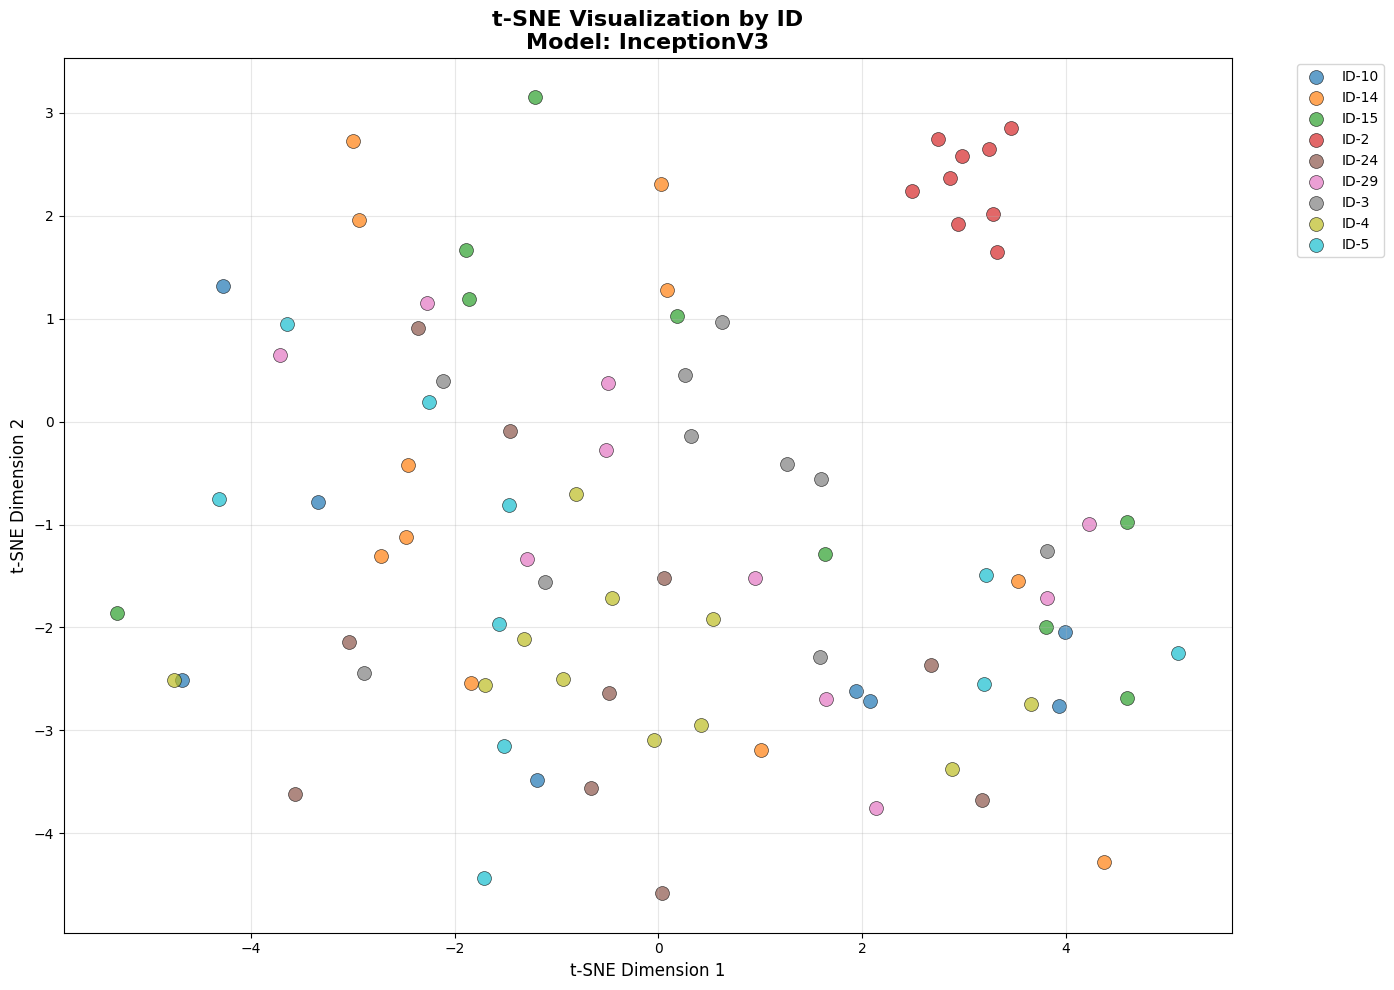


[ResNet50] Computing t-SNE...
  ✓ Saved: output/tsne_ResNet50_20251211_025946.png
  ✓ Saved: output/tsne_ResNet50_20251211_025946.png


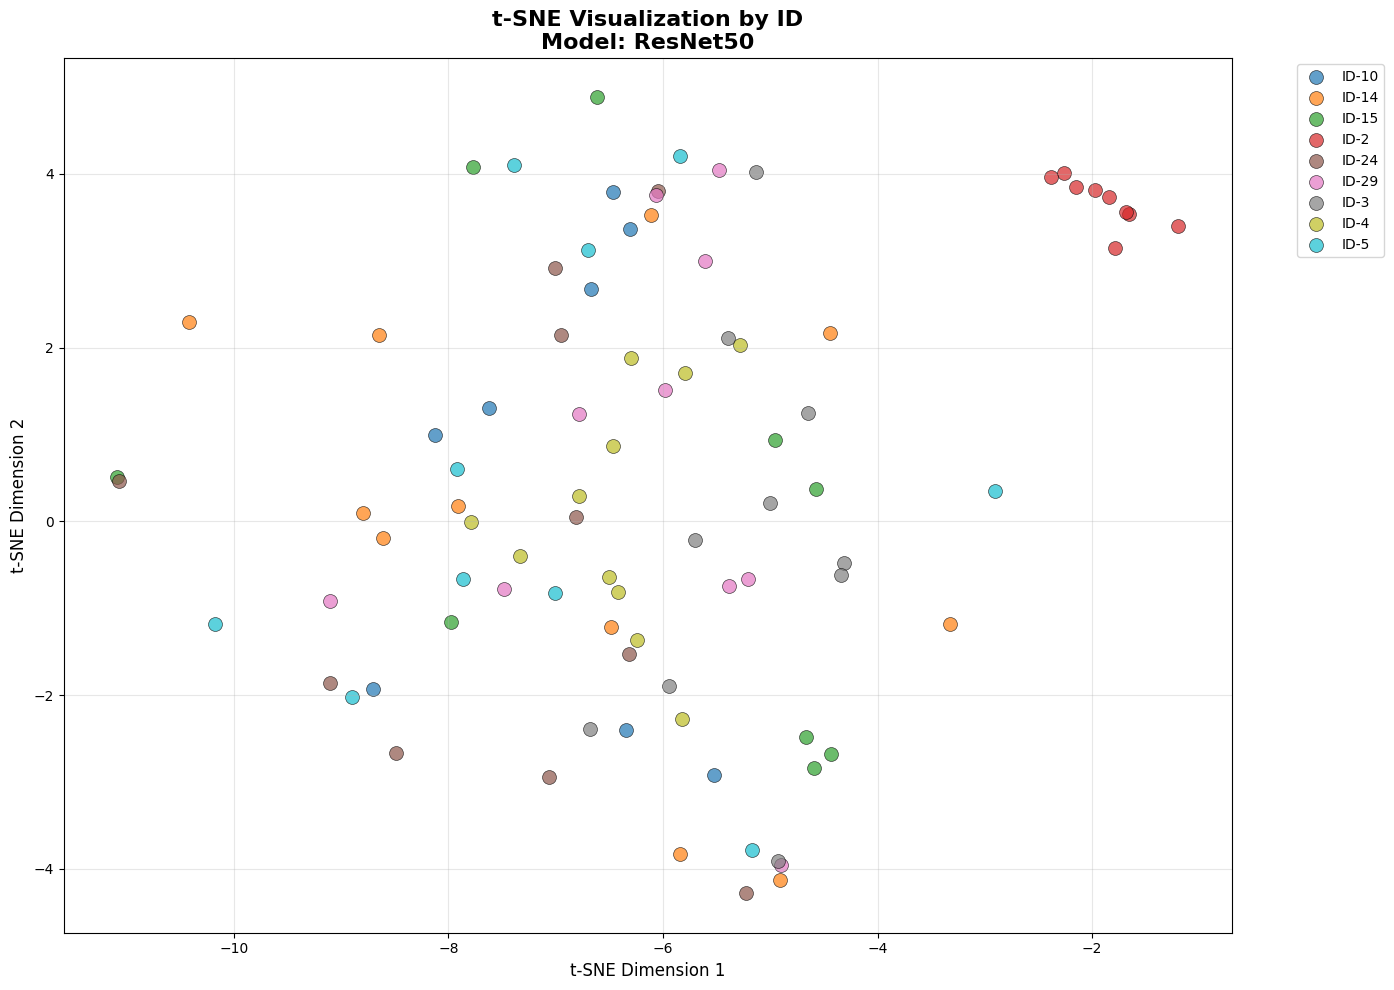


[FaceNet-InceptionResnetV1] Computing t-SNE...
  ✓ Saved: output/tsne_FaceNet_InceptionResnetV1_20251211_025946.png
  ✓ Saved: output/tsne_FaceNet_InceptionResnetV1_20251211_025946.png


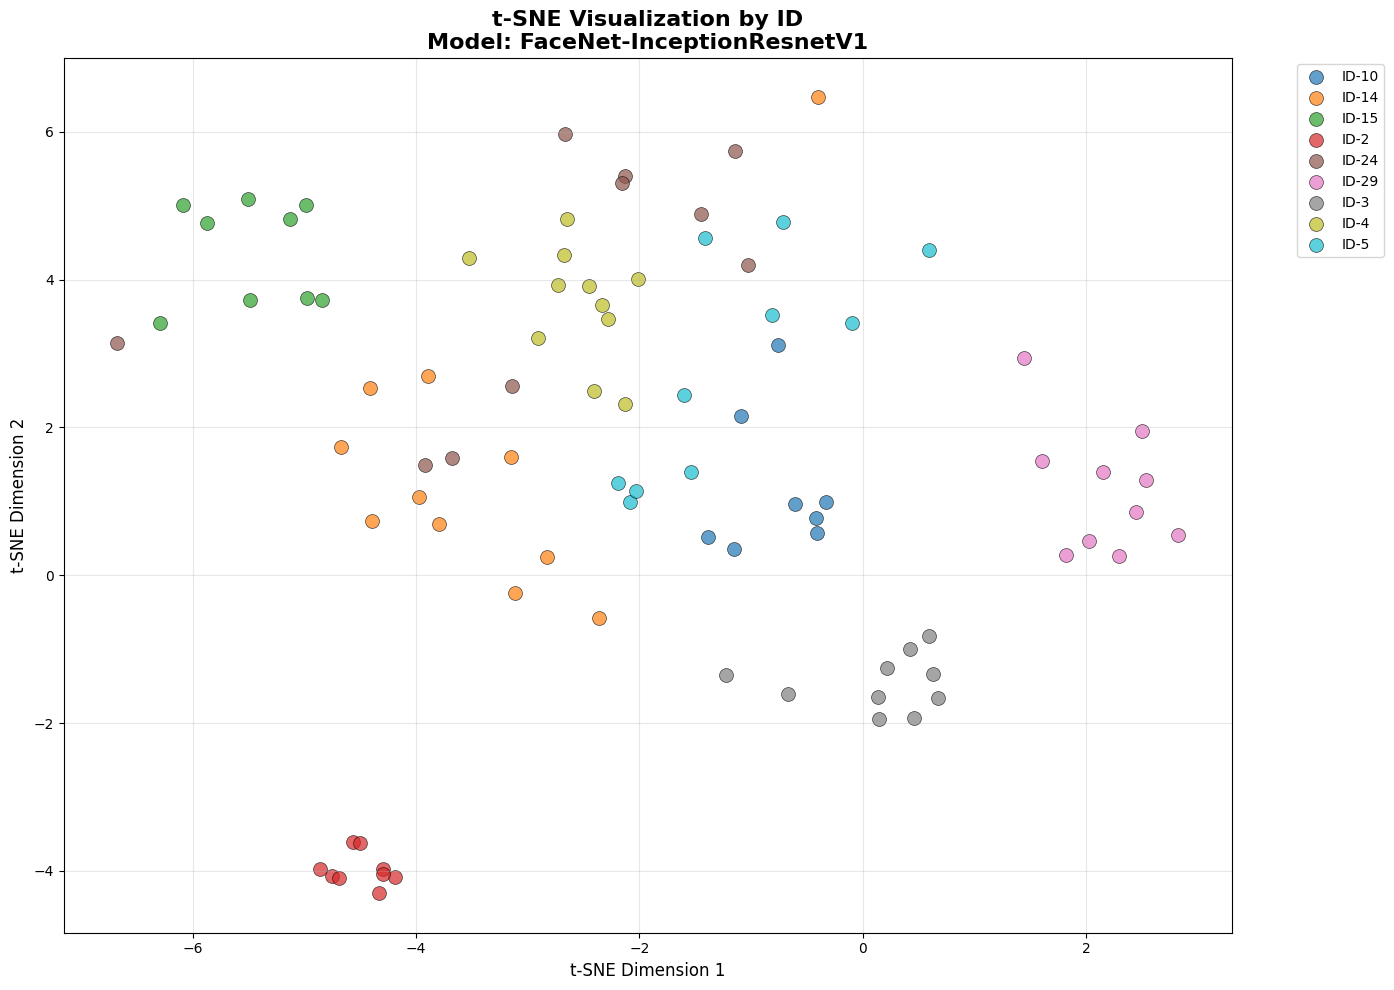


✓ All t-SNE visualizations generated


In [33]:
def load_tsne_images(crop_path):
    """
    Load images from datahub/crop/tsne/ folder organized by ID
    
    Returns:
        image_paths: List of image paths
        labels: List of ID labels (corresponding to each image)
    """
    tsne_path = Path(crop_path) / 'tsne'
    id_folders = sorted([f for f in tsne_path.iterdir() if f.is_dir()])
    
    image_paths = []
    labels = []
    
    for id_folder in id_folders:
        id_name = id_folder.name
        images = sorted(list(id_folder.glob('*.jpg')) + list(id_folder.glob('*.png')))
        
        for img_path in images:
            image_paths.append(img_path)
            labels.append(f'ID-{id_name}')
    
    return image_paths, labels

def compute_tsne(embeddings, perplexity=30, random_state=42):
    """
    Compute t-SNE dimensionality reduction
    """
    # Adjust perplexity if needed
    n_samples = len(embeddings)
    perplexity = min(perplexity, (n_samples - 1) // 3)
    
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=1000,
        random_state=random_state,
        metric='cosine'
    )
    return tsne.fit_transform(embeddings)

def plot_tsne(embeddings_2d, labels, title, save_path=None):
    """
    Plot t-SNE visualization with different colors for each ID
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    
    unique_labels = sorted(set(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    for idx, label in enumerate(unique_labels):
        mask = np.array(labels) == label
        ax.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[colors[idx]],
            label=label,
            alpha=0.7,
            s=100,
            edgecolors='black',
            linewidths=0.5
        )
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {save_path}")
    
    plt.show()
    return fig

# Load t-SNE images
print("="*80)
print("LOADING IMAGES FOR t-SNE")
print("="*80)

tsne_image_paths, tsne_labels = load_tsne_images(crop_path)
print(f"✓ Loaded {len(tsne_image_paths)} images from tsne folder")
print(f"  IDs: {sorted(set(tsne_labels))}")

# Extract embeddings for t-SNE visualization
print("\n" + "="*80)
print("EXTRACTING EMBEDDINGS FOR t-SNE")
print("="*80)

tsne_embeddings_all = {}

for model_name, model in models.items():
    print(f"\n[{model_name}]")
    embeddings = []
    
    for i, img_path in enumerate(tsne_image_paths):
        try:
            preprocessed = model.preprocess(img_path)
            features = model.inference(preprocessed)
            embedding = model.postprocess(features, output_type='embedding')
            embeddings.append(embedding[0])
            
            if (i + 1) % 20 == 0:
                print(f"  Processed {i + 1}/{len(tsne_image_paths)} images")
        except Exception as e:
            print(f"  ✗ Error processing {img_path}: {e}")
            if embeddings:
                embeddings.append(np.zeros_like(embeddings[0]))
            else:
                embeddings.append(np.zeros(512))
    
    tsne_embeddings_all[model_name] = np.array(embeddings)
    print(f"✓ Extracted {len(embeddings)} embeddings, shape: {tsne_embeddings_all[model_name].shape}")

# Generate t-SNE visualizations
print("\n" + "="*80)
print("t-SNE VISUALIZATION GENERATION")
print("="*80)

output_dir = Path('./output')
output_dir.mkdir(exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

tsne_results = {}

for model_name, embeddings in tsne_embeddings_all.items():
    print(f"\n[{model_name}] Computing t-SNE...")
    
    # Compute t-SNE
    embeddings_2d = compute_tsne(embeddings)
    tsne_results[model_name] = {
        'embeddings_2d': embeddings_2d,
        'labels': tsne_labels
    }
    
    # Plot and save
    safe_name = model_name.replace(' ', '_').replace('-', '_')
    save_path = output_dir / f'tsne_{safe_name}_{timestamp}.png'
    
    title = f't-SNE Visualization by ID\nModel: {model_name}'
    plot_tsne(embeddings_2d, tsne_labels, title, save_path)

print("\n" + "="*80)
print("✓ All t-SNE visualizations generated")
print("="*80)

## 6. Calculate Clustering Metrics

**Clustering Quality Metrics Explained:**

### 1. Within-Cluster Distance (Càng nhỏ càng tốt)
- **Định nghĩa:** Khoảng cách trung bình giữa các điểm **trong cùng một cluster**
- **Ý nghĩa:** Đo độ "chặt" của mỗi cluster (Real, Fake, Fake 45°)
- **Tính toán:** Với mỗi cluster, tính khoảng cách Euclidean giữa tất cả các cặp điểm trong cluster đó, rồi lấy trung bình
- **Mong muốn:** Giá trị nhỏ = các điểm trong cùng nhóm gần nhau = cluster tập trung

### 2. Between-Cluster Distance (Càng lớn càng tốt)
- **Định nghĩa:** Khoảng cách trung bình giữa các điểm **thuộc các cluster khác nhau**
- **Ý nghĩa:** Đo độ "xa" giữa các cluster (Real vs Fake vs Fake 45°)
- **Tính toán:** Với mỗi điểm trong cluster A, tính khoảng cách đến tất cả điểm trong cluster B, C..., rồi lấy trung bình
- **Mong muốn:** Giá trị lớn = các nhóm khác nhau xa nhau = phân tách tốt

### 3. Separation Ratio (Càng lớn càng tốt)
- **Công thức:** `Separation Ratio = Between-Cluster Distance / Within-Cluster Distance`
- **Ý nghĩa:** Tỷ lệ giữa "độ xa của các cluster" và "độ chặt của mỗi cluster"
- **Giải thích trực quan:** 
  - Ratio cao = Các cluster xa nhau VÀ mỗi cluster rất tập trung
  - Ratio thấp = Các cluster gần nhau HOẶC mỗi cluster rải rác
- **Ví dụ thực tế:**
  - Ratio = 2.0: Khoảng cách giữa Real-Fake gấp 2 lần khoảng cách trong mỗi nhóm
  - Ratio = 0.5: Các cluster chồng lấn lẫn nhau, khó phân biệt

**📊 Ý nghĩa cho bài toán Real vs Fake:**
- **High Separation Ratio** → Model có thể phân biệt rõ ràng Real và Fake trong không gian embedding
- **Low Separation Ratio** → Real và Fake trộn lẫn, model khó phân biệt

In [34]:
def calculate_cluster_metrics(embeddings_2d, labels):
    """
    Calculate clustering quality metrics
    
    Metrics explained:
    - Within-cluster distance: Average distance between points in SAME cluster (same ID)
      → Lower is better (tight clusters)
    - Between-cluster distance: Average distance between points in DIFFERENT clusters (different IDs)
      → Higher is better (well-separated clusters)
    - Separation ratio: Between / Within
      → Higher is better (indicates clear cluster boundaries by ID)
    """
    unique_labels = sorted(set(labels))
    labels_array = np.array(labels)
    
    within_distances = []
    between_distances = []
    
    for label in unique_labels:
        mask = labels_array == label
        cluster_points = embeddings_2d[mask]
        
        # Within-cluster distances (khoảng cách TRONG cluster - cùng ID)
        # Tính khoảng cách giữa tất cả các cặp điểm trong cùng cluster
        if len(cluster_points) > 1:
            dist_matrix = squareform(pdist(cluster_points, metric='euclidean'))
            within_dist = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
            within_distances.extend(within_dist)
        
        # Between-cluster distances (khoảng cách GIỮA các cluster - khác ID)
        # Tính khoảng cách từ mỗi điểm trong cluster này đến tất cả điểm trong cluster khác
        for other_label in unique_labels:
            if other_label != label:
                other_mask = labels_array == other_label
                other_points = embeddings_2d[other_mask]
                
                for point in cluster_points:
                    dists = np.linalg.norm(other_points - point, axis=1)
                    between_distances.extend(dists)
    
    within_mean = float(np.mean(within_distances)) if within_distances else 0
    between_mean = float(np.mean(between_distances)) if between_distances else 0
    separation_ratio = between_mean / within_mean if within_mean > 0 else 0
    
    return {
        'within_cluster_distance': within_mean,
        'between_cluster_distance': between_mean,
        'separation_ratio': separation_ratio
    }

# Calculate metrics for all models
print("="*80)
print("CLUSTERING METRICS CALCULATION (By ID)")
print("="*80)

clustering_metrics = {}

for model_name, tsne_data in tsne_results.items():
    print(f"\n[{model_name}]")
    metrics = calculate_cluster_metrics(tsne_data['embeddings_2d'], tsne_data['labels'])
    clustering_metrics[model_name] = metrics
    
    print(f"  Within-cluster distance: {metrics['within_cluster_distance']:.4f}")
    print(f"    → Khoảng cách trung bình giữa các ảnh CÙNG ID")
    print(f"    → Càng NHỎ càng tốt (ảnh cùng ID càng gần nhau)")
    
    print(f"  Between-cluster distance: {metrics['between_cluster_distance']:.4f}")
    print(f"    → Khoảng cách trung bình giữa các ảnh KHÁC ID")
    print(f"    → Càng LỚN càng tốt (các ID càng xa nhau)")
    
    print(f"  Separation ratio: {metrics['separation_ratio']:.4f}")
    print(f"    → Tỷ lệ = Between / Within")
    print(f"    → Càng LỚN càng tốt (phân biệt ID rõ ràng)")
    
    # Interpretation
    ratio = metrics['separation_ratio']
    if ratio >= 2.0:
        quality = "✓ EXCELLENT - Phân tách ID rất rõ ràng"
    elif ratio >= 1.5:
        quality = "✓ GOOD - Phân tách ID tốt"
    elif ratio >= 1.0:
        quality = "⚠ FAIR - Phân tách ID vừa phải"
    else:
        quality = "✗ POOR - Các ID chồng lấn"
    print(f"    → {quality}")

# Create comparison DataFrame
df_clustering = pd.DataFrame(clustering_metrics).T
df_clustering = df_clustering.round(4)
df_clustering = df_clustering.sort_values('separation_ratio', ascending=False)

print("\n" + "="*80)
print("CLUSTERING METRICS COMPARISON")
print("="*80)
print(df_clustering.to_string())
print("\n✓ Higher separation ratio = Better ID clustering")
print("\n📊 Giải thích:")
print("  • Within-cluster ↓ (nhỏ) = Ảnh cùng ID tập trung chặt")
print("  • Between-cluster ↑ (lớn) = Các ID khác nhau xa nhau")
print("  • Separation Ratio ↑ (lớn) = Model phân biệt tốt các ID khác nhau")

CLUSTERING METRICS CALCULATION (By ID)

[InceptionV3]
  Within-cluster distance: 3.6083
    → Khoảng cách trung bình giữa các ảnh CÙNG ID
    → Càng NHỎ càng tốt (ảnh cùng ID càng gần nhau)
  Between-cluster distance: 4.3389
    → Khoảng cách trung bình giữa các ảnh KHÁC ID
    → Càng LỚN càng tốt (các ID càng xa nhau)
  Separation ratio: 1.2025
    → Tỷ lệ = Between / Within
    → Càng LỚN càng tốt (phân biệt ID rõ ràng)
    → ⚠ FAIR - Phân tách ID vừa phải

[ResNet50]
  Within-cluster distance: 3.3441
    → Khoảng cách trung bình giữa các ảnh CÙNG ID
    → Càng NHỎ càng tốt (ảnh cùng ID càng gần nhau)
  Between-cluster distance: 4.2067
    → Khoảng cách trung bình giữa các ảnh KHÁC ID
    → Càng LỚN càng tốt (các ID càng xa nhau)
  Separation ratio: 1.2579
    → Tỷ lệ = Between / Within
    → Càng LỚN càng tốt (phân biệt ID rõ ràng)
    → ⚠ FAIR - Phân tách ID vừa phải

[FaceNet-InceptionResnetV1]
  Within-cluster distance: 1.5850
    → Khoảng cách trung bình giữa các ảnh CÙNG ID
   

## 6.1 Detect Cross-ID Duplicate Pairs

**Purpose:** Find image pairs from different IDs that have high similarity (potential duplicates)  
**Method:** Calculate pairwise distances in t-SNE 2D space between all cross-ID pairs

In [ ]:
def find_cross_id_duplicates(embeddings_2d, labels, image_paths, threshold=3.0, top_n=10):
    """
    Find pairs of images from DIFFERENT IDs that are close in t-SNE space
    (potential duplicates or mismatches)
    
    Args:
        embeddings_2d: 2D t-SNE embeddings (N x 2)
        labels: List of ID labels (e.g., ['ID-10', 'ID-14', ...])
        image_paths: List of image paths corresponding to embeddings
        threshold: Distance threshold for considering as duplicate (lower = stricter)
        top_n: Number of top duplicate pairs to return
    
    Returns:
        List of duplicate pairs with metadata
    """
    from scipy.spatial.distance import euclidean
    
    labels_array = np.array(labels)
    duplicate_pairs = []
    
    # Calculate pairwise distances only for cross-ID pairs
    for i in range(len(embeddings_2d)):
        for j in range(i + 1, len(embeddings_2d)):
            # Only consider pairs from DIFFERENT IDs
            if labels_array[i] != labels_array[j]:
                dist = euclidean(embeddings_2d[i], embeddings_2d[j])
                
                # If distance is below threshold, it's a potential duplicate
                if dist < threshold:
                    duplicate_pairs.append({
                        'id1': labels_array[i],
                        'id2': labels_array[j],
                        'image1': str(image_paths[i]),
                        'image2': str(image_paths[j]),
                        'distance': float(dist),
                        'tsne_coord1': embeddings_2d[i].tolist(),
                        'tsne_coord2': embeddings_2d[j].tolist()
                    })
    
    # Sort by distance (smallest first = most similar)
    duplicate_pairs.sort(key=lambda x: x['distance'])
    
    return duplicate_pairs[:top_n]

print("="*80)
print("CROSS-ID DUPLICATE DETECTION")
print("="*80)
print("\nSearching for image pairs from DIFFERENT IDs that are suspiciously similar...")
print("(Potential duplicates or data quality issues)")
print("="*80)

duplicate_detection_results = {}

for model_name, tsne_data in tsne_results.items():
    print(f"\n[{model_name}]")
    
    # Find duplicates
    duplicates = find_cross_id_duplicates(
        tsne_data['embeddings_2d'],
        tsne_data['labels'],
        tsne_image_paths,
        threshold=3.0,
        top_n=10
    )
    
    duplicate_detection_results[model_name] = duplicates
    
    print(f"  Found {len(duplicates)} potential cross-ID duplicate pairs")
    
    if len(duplicates) > 0:
        print(f"\n  Top 4 Most Similar Cross-ID Pairs:")
        print(f"  " + "-"*76)
        
        for idx, dup in enumerate(duplicates[:4], 1):
            print(f"\n  [{idx}] Distance: {dup['distance']:.4f}")
            print(f"      ID 1: {dup['id1']} → {Path(dup['image1']).name}")
            print(f"      ID 2: {dup['id2']} → {Path(dup['image2']).name}")
            print(f"      t-SNE coords: ({dup['tsne_coord1'][0]:.2f}, {dup['tsne_coord1'][1]:.2f}) ↔ "
                  f"({dup['tsne_coord2'][0]:.2f}, {dup['tsne_coord2'][1]:.2f})")
    else:
        print("  ✓ No cross-ID duplicates found (all IDs well-separated)")

# Create summary table for top 4 duplicates from best model
if duplicate_detection_results:
    best_model = best_clustering
    top_duplicates = duplicate_detection_results[best_model][:4]
    
    if len(top_duplicates) > 0:
        print("\n" + "="*80)
        print(f"TOP 4 CROSS-ID DUPLICATES (Model: {best_model})")
        print("="*80)
        
        duplicate_summary = []
        for idx, dup in enumerate(top_duplicates, 1):
            duplicate_summary.append({
                'Rank': idx,
                'ID 1': dup['id1'],
                'Image 1': Path(dup['image1']).name,
                'ID 2': dup['id2'],
                'Image 2': Path(dup['image2']).name,
                'Distance': f"{dup['distance']:.4f}"
            })
        
        df_duplicates = pd.DataFrame(duplicate_summary)
        print(df_duplicates.to_string(index=False))
        
        print("\n⚠️ WARNING: These pairs are from DIFFERENT IDs but very close in embedding space")
        print("   → Possible data quality issues:")
        print("     • Mislabeled images (wrong ID assigned)")
        print("     • Actual duplicate images with different ID labels")
        print("     • Very similar-looking individuals")
        
        print("\n💡 Recommendation:")
        print("   → Manually inspect these image pairs")
        print("   → Verify ID labels are correct")
        print("   → Check for actual image duplicates in dataset")

print("\n" + "="*80)
print("✓ Cross-ID duplicate detection complete")
print("="*80)

## 7. Calculate Cosine Similarity (Fake vs Fake 45°)

**Method:** Compare fake frontal images vs fake 45° images pairwise by ID  
**Purpose:** Measure how pose change (frontal → 45°) affects embedding similarity

In [35]:
def calculate_cosine_similarity_pairwise(embeddings1, embeddings2, label1, label2):
    """
    Calculate cosine similarity between two sets of embeddings pairwise
    Assumes embeddings are aligned by ID (same order)
    
    Args:
        embeddings1: First set of embeddings (e.g., fake)
        embeddings2: Second set of embeddings (e.g., fake_45)
        label1: Label for first set
        label2: Label for second set
    """
    if len(embeddings1) != len(embeddings2):
        raise ValueError(f"Mismatch: {len(embeddings1)} {label1} vs {len(embeddings2)} {label2} images")
    
    similarities = []
    
    for i in range(len(embeddings1)):
        # Normalize embeddings
        emb1_norm = embeddings1[i] / (np.linalg.norm(embeddings1[i]) + 1e-8)
        emb2_norm = embeddings2[i] / (np.linalg.norm(embeddings2[i]) + 1e-8)
        
        # Cosine similarity = dot product of normalized vectors
        similarity = float(np.dot(emb1_norm, emb2_norm))
        similarities.append(similarity)
    
    stats = {
        'mean': float(np.mean(similarities)),
        'std': float(np.std(similarities)),
        'min': float(np.min(similarities)),
        'max': float(np.max(similarities)),
        'num_pairs': len(similarities),
        'similarities': similarities
    }
    
    return stats

print("="*80)
print("COSINE SIMILARITY CALCULATION")
print("="*80)
print("\nComparing Fake (Frontal) vs Fake 45° images:")
print("  → Measure how pose change affects embedding similarity")
print("  → Higher similarity = model robust to pose variation")
print("="*80)

cosine_similarity_results = {}

for model_name, embeddings_dict in all_embeddings.items():
    print(f"\n[{model_name}]")
    
    # Calculate Fake vs Fake 45°
    fake_vs_fake45 = calculate_cosine_similarity_pairwise(
        embeddings_dict['fake'],
        embeddings_dict['fake_45'],
        'Fake (Frontal)',
        'Fake 45°'
    )
    
    cosine_similarity_results[model_name] = {
        'fake_vs_fake_45': fake_vs_fake45
    }
    
    print(f"  Fake (Frontal) vs Fake 45°:")
    print(f"    Mean: {fake_vs_fake45['mean']:.4f} ± {fake_vs_fake45['std']:.4f}")
    print(f"    Range: [{fake_vs_fake45['min']:.4f}, {fake_vs_fake45['max']:.4f}]")
    
    # Interpretation
    mean_sim = fake_vs_fake45['mean']
    if mean_sim >= 0.85:
        interpretation = "✓ EXCELLENT - Rất ổn định với thay đổi pose"
        quality = "Model không bị ảnh hưởng nhiều bởi góc chụp"
    elif mean_sim >= 0.70:
        interpretation = "✓ GOOD - Tốt với thay đổi pose"
        quality = "Model chấp nhận được sự thay đổi góc 45°"
    elif mean_sim >= 0.50:
        interpretation = "⚠ FAIR - Bị ảnh hưởng vừa phải"
        quality = "Pose 45° làm giảm độ tương đồng đáng kể"
    else:
        interpretation = "✗ POOR - Rất nhạy cảm với pose"
        quality = "Model không robust với thay đổi góc chụp"
    
    print(f"    {interpretation}")
    print(f"    → {quality}")

# Create comparison DataFrame
df_cosine = pd.DataFrame({
    model_name: {
        'Mean': stats['fake_vs_fake_45']['mean'],
        'Std': stats['fake_vs_fake_45']['std'],
        'Min': stats['fake_vs_fake_45']['min'],
        'Max': stats['fake_vs_fake_45']['max']
    }
    for model_name, stats in cosine_similarity_results.items()
}).T.round(4).sort_values('Mean', ascending=False)

print("\n" + "="*80)
print("COSINE SIMILARITY COMPARISON: Fake vs Fake 45°")
print("="*80)
print(df_cosine.to_string())

print("\n✓ Higher mean similarity = Model more robust to pose variation")
print("\n📊 Giải thích:")
print("  • High Similarity (>0.85): Model không nhạy cảm với góc chụp")
print("  • Medium Similarity (0.70-0.85): Model chấp nhận được thay đổi pose")
print("  • Low Similarity (<0.70): Model bị ảnh hưởng nhiều bởi góc chụp")
print("\n💡 Ý nghĩa:")
print("  - Model tốt nên có similarity cao → Nhận diện ổn định dù thay đổi góc")
print("  - Nếu similarity thấp → Model phụ thuộc nhiều vào góc chụp")

COSINE SIMILARITY CALCULATION

Comparing Fake (Frontal) vs Fake 45° images:
  → Measure how pose change affects embedding similarity
  → Higher similarity = model robust to pose variation

[InceptionV3]
  Fake (Frontal) vs Fake 45°:
    Mean: 0.8079 ± 0.0428
    Range: [0.7426, 0.8867]
    ✓ GOOD - Tốt với thay đổi pose
    → Model chấp nhận được sự thay đổi góc 45°

[ResNet50]
  Fake (Frontal) vs Fake 45°:
    Mean: 0.8370 ± 0.0380
    Range: [0.7574, 0.8903]
    ✓ GOOD - Tốt với thay đổi pose
    → Model chấp nhận được sự thay đổi góc 45°

[FaceNet-InceptionResnetV1]
  Fake (Frontal) vs Fake 45°:
    Mean: 0.7844 ± 0.1042
    Range: [0.6106, 0.9335]
    ✓ GOOD - Tốt với thay đổi pose
    → Model chấp nhận được sự thay đổi góc 45°

COSINE SIMILARITY COMPARISON: Fake vs Fake 45°
                             Mean     Std     Min     Max
ResNet50                   0.8370  0.0380  0.7574  0.8903
InceptionV3                0.8079  0.0428  0.7426  0.8867
FaceNet-InceptionResnetV1  0.7844  0

## 8. Calculate FID Score (Real vs Fake Distribution)

**Method:** Compare embedding distributions between Real and Fake images  
**Purpose:** Measure how similar fake images are to real images statistically

In [36]:
def calculate_fid_score(embeddings1, embeddings2):
    """
    Calculate Frechet Inception Distance (FID) between two sets of embeddings
    
    FID measures the distance between two multivariate Gaussians:
    FID = ||μ₁ - μ₂||² + Tr(Σ₁ + Σ₂ - 2√(Σ₁Σ₂))
    
    Lower FID = more similar distributions
    """
    from scipy import linalg
    
    # Calculate mean and covariance
    mu1 = np.mean(embeddings1, axis=0)
    mu2 = np.mean(embeddings2, axis=0)
    
    sigma1 = np.cov(embeddings1, rowvar=False)
    sigma2 = np.cov(embeddings2, rowvar=False)
    
    # Calculate FID
    diff = mu1 - mu2
    
    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    # Handle numerical errors
    if not np.isfinite(covmean).all():
        print("  Warning: Adding epsilon for numerical stability")
        offset = np.eye(sigma1.shape[0]) * 1e-6
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # Remove imaginary component if present (numerical error)
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError(f"Imaginary component too large: {m}")
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    
    return float(fid)

print("="*80)
print("FID SCORE CALCULATION")
print("="*80)
print("\nComparing distributions: Real vs Fake (frontal)")
print("  → Lower FID = Fake images more similar to Real images")
print("  → Measures overall quality of generated faces")
print("="*80)

fid_results = {}

for model_name, embeddings_dict in all_embeddings.items():
    print(f"\n[{model_name}]")
    
    real_embeddings = embeddings_dict['real']
    fake_embeddings = embeddings_dict['fake']
    
    print(f"  Real: {len(real_embeddings)} embeddings")
    print(f"  Fake: {len(fake_embeddings)} embeddings")
    
    # Check minimum requirements
    if len(real_embeddings) < 2 or len(fake_embeddings) < 2:
        print(f"  ✗ Error: Need at least 2 embeddings in each group for FID")
        fid_results[model_name] = {'real_vs_fake': None}
        continue
    
    try:
        # Calculate FID: Real vs Fake
        fid_real_fake = calculate_fid_score(real_embeddings, fake_embeddings)
        
        fid_results[model_name] = {
            'real_vs_fake': fid_real_fake
        }
        
        print(f"  Real vs Fake:")
        print(f"    FID Score: {fid_real_fake:.4f}")
        
        # Interpretation
        if fid_real_fake < 50:
            interpretation = "✓ EXCELLENT - Rất giống Real"
            quality = "Fake images có distribution rất gần Real"
        elif fid_real_fake < 100:
            interpretation = "✓ GOOD - Khá giống Real"
            quality = "Fake images có chất lượng tốt"
        elif fid_real_fake < 200:
            interpretation = "⚠ ACCEPTABLE - Chấp nhận được"
            quality = "Fake images có sự khác biệt vừa phải"
        else:
            interpretation = "✗ POOR - Khác biệt lớn"
            quality = "Fake images khác xa Real images"
        
        print(f"    {interpretation}")
        print(f"    → {quality}")
        
    except Exception as e:
        print(f"  ✗ Error calculating FID: {e}")
        fid_results[model_name] = {'real_vs_fake': None}

# Create comparison DataFrame
df_fid = pd.DataFrame({
    'Model': [],
    'FID Score': []
})

for model_name, scores in fid_results.items():
    if scores['real_vs_fake'] is not None:
        df_fid = pd.concat([df_fid, pd.DataFrame({
            'Model': [model_name],
            'FID Score': [scores['real_vs_fake']]
        })], ignore_index=True)

if not df_fid.empty:
    df_fid = df_fid.sort_values('FID Score')
    print("\n" + "="*80)
    print("FID COMPARISON: Real vs Fake")
    print("="*80)
    print(df_fid.to_string(index=False))
    
    print("\n✓ Lower FID score = Better fake image quality")
    print("\n📊 Giải thích:")
    print("  • FID đo khoảng cách giữa 2 phân phối (Real vs Fake)")
    print("  • FID thấp = Fake có distribution giống Real")
    print("  • FID cao = Fake có distribution khác Real")
    print("\n💡 Ý nghĩa:")
    print("  - FID thấp → Fake images có chất lượng cao, giống Real")
    print("  - FID cao → Fake images còn khác xa Real, cần cải thiện")
else:
    print("\n✗ No valid FID results computed")

print("\nInterpretation Guidelines:")
print("  < 50:  Excellent - Fake rất giống Real")
print("  < 100: Good - Fake khá giống Real")
print("  < 200: Acceptable - Chấp nhận được")
print("  > 200: Poor - Fake khác xa Real")

FID SCORE CALCULATION

Comparing distributions: Real vs Fake (frontal)
  → Lower FID = Fake images more similar to Real images
  → Measures overall quality of generated faces

[InceptionV3]
  Real: 10 embeddings
  Fake: 10 embeddings
  Real vs Fake:
    FID Score: 59.0548
    ✓ GOOD - Khá giống Real
    → Fake images có chất lượng tốt

[ResNet50]
  Real: 10 embeddings
  Fake: 10 embeddings
  Real vs Fake:
    FID Score: 59.0548
    ✓ GOOD - Khá giống Real
    → Fake images có chất lượng tốt

[ResNet50]
  Real: 10 embeddings
  Fake: 10 embeddings
  Real vs Fake:
    FID Score: 47.3147
    ✓ EXCELLENT - Rất giống Real
    → Fake images có distribution rất gần Real

[FaceNet-InceptionResnetV1]
  Real: 10 embeddings
  Fake: 10 embeddings
  Real vs Fake:
    FID Score: 47.3147
    ✓ EXCELLENT - Rất giống Real
    → Fake images có distribution rất gần Real

[FaceNet-InceptionResnetV1]
  Real: 10 embeddings
  Fake: 10 embeddings
  Real vs Fake:
    FID Score: 0.1190
    ✓ EXCELLENT - Rất giốn

## 9. Generate Comprehensive Report

In [ ]:
# Create comprehensive report
report = {
    'timestamp': timestamp,
    'dataset': dataset_info,
    'models': list(models.keys()),
    'metrics': {
        'clustering': clustering_metrics,
        'cosine_similarity': cosine_similarity_results,
        'fid': fid_results,
        'cross_id_duplicates': duplicate_detection_results
    }
}

# Save report as JSON
report_file = output_dir / f'comprehensive_report_{timestamp}.json'
with open(report_file, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print(f"✓ Comprehensive report saved to: {report_file}")

✓ Comprehensive report saved to: output/comprehensive_report_20251211_025946.json


## 10. Summary Comparison Table

In [38]:
# Create summary comparison table
summary_data = []

for model_name in models.keys():
    summary_data.append({
        'Model': model_name,
        'Separation Ratio': clustering_metrics[model_name]['separation_ratio'],
        'Cosine (Fake vs Fake45)': cosine_similarity_results[model_name]['fake_vs_fake_45']['mean'],
        'FID (Real vs Fake)': fid_results[model_name]['real_vs_fake']
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.round(4)

# Sort by separation ratio (best clustering metric)
df_summary = df_summary.sort_values('Separation Ratio', ascending=False)

print("="*80)
print("FINAL SUMMARY - ALL METRICS")
print("="*80)
print(df_summary.to_string(index=False))
print("\n" + "="*80)
print("Interpretation:")
print("  - Separation Ratio: Higher is better (good ID clustering)")
print("  - Cosine Similarity: Higher is better (pose robust)")
print("  - FID Score: Lower is better (fake similar to real)")
print("="*80)

# Identify best model for each metric
best_clustering = df_summary.loc[df_summary['Separation Ratio'].idxmax(), 'Model']
best_cosine = df_summary.loc[df_summary['Cosine (Fake vs Fake45)'].idxmax(), 'Model']

valid_fid = df_summary[df_summary['FID (Real vs Fake)'].notna()]
best_fid = valid_fid.loc[valid_fid['FID (Real vs Fake)'].idxmin(), 'Model'] if not valid_fid.empty else 'N/A'

print("\n🏆 BEST PERFORMERS:")
print(f"  Best ID Clustering: {best_clustering}")
print(f"    → Model tốt nhất để phân biệt các ID khác nhau")
print(f"  Best Pose Robustness: {best_cosine}")
print(f"    → Model ổn định nhất với thay đổi góc chụp")
print(f"  Best Fake Quality: {best_fid}")
print(f"    → Model đánh giá Fake giống Real nhất")

FINAL SUMMARY - ALL METRICS
                    Model  Separation Ratio  Cosine (Fake vs Fake45)  FID (Real vs Fake)
FaceNet-InceptionResnetV1            3.1198                   0.7844              0.1190
                 ResNet50            1.2579                   0.8370             47.3147
              InceptionV3            1.2025                   0.8079             59.0548

Interpretation:
  - Separation Ratio: Higher is better (good ID clustering)
  - Cosine Similarity: Higher is better (pose robust)
  - FID Score: Lower is better (fake similar to real)

🏆 BEST PERFORMERS:
  Best ID Clustering: FaceNet-InceptionResnetV1
    → Model tốt nhất để phân biệt các ID khác nhau
  Best Pose Robustness: ResNet50
    → Model ổn định nhất với thay đổi góc chụp
  Best Fake Quality: FaceNet-InceptionResnetV1
    → Model đánh giá Fake giống Real nhất


## 11. Generate Notion-Ready Report (Markdown)

In [ ]:
# Generate Notion-ready markdown report
notion_report = f"""
# Face Embedding Analysis Report

**Date:** {datetime.now().strftime("%B %d, %Y")}
**Dataset:** Face images from `datahub/crop`

---

## 📊 Dataset Overview

- **Total IDs:** {dataset_info['total_ids']}
- **IDs:** {', '.join(dataset_info['ids'])}

### Image Distribution

| Category | Count |
|----------|-------|
| Real Images | {dataset_info['real_images']} |
| Fake Images (Frontal) | {dataset_info['fake_images']} |
| Fake Images (45°) | {dataset_info['fake_45_images']} |
| **Total** | **{dataset_info['total_images']}** |

### t-SNE Images
- **Source:** `datahub/crop/tsne/` (organized by ID)
- **Purpose:** Visualize ID clustering quality

---

## 🤖 Models Compared

1. **InceptionV3** - Pretrained on ImageNet, 2048-dimensional embeddings
2. **ResNet50** - Pretrained on ImageNet, 2048-dimensional embeddings  
3. **FaceNet InceptionResnetV1** - Pretrained on VGGFace2, 512-dimensional embeddings (specialized for faces)

---

## 📈 t-SNE Visualizations (ID Clustering)

t-SNE visualizations showing how well each model clusters images by ID.

### InceptionV3
![InceptionV3 t-SNE](tsne_InceptionV3_{timestamp}.png)

### ResNet50
![ResNet50 t-SNE](tsne_ResNet50_{timestamp}.png)

### FaceNet InceptionResnetV1
![FaceNet t-SNE](tsne_FaceNet_InceptionResnetV1_{timestamp}.png)

**Expected Outcome:** Images from same ID should cluster together.

---

## 🎯 Clustering Quality Metrics (ID Separation)

**Separation Ratio** = Between-cluster distance / Within-cluster distance  
*(Higher is better - indicates clear ID separation)*

| Model | Within Distance | Between Distance | Separation Ratio |
|-------|----------------|------------------|------------------|
"""

for model_name in df_clustering.index:
    metrics = clustering_metrics[model_name]
    notion_report += f"| {model_name} | {metrics['within_cluster_distance']:.4f} | {metrics['between_cluster_distance']:.4f} | **{metrics['separation_ratio']:.4f}** |\n"

notion_report += f"""

### Interpretation
- ✅ **Best:** {best_clustering} (highest separation ratio)
- Higher ratio = better ID clustering
- Within-cluster ↓ = images of same ID are close together
- Between-cluster ↑ = different IDs are far apart

---

## 🔄 Cosine Similarity (Pose Robustness)

**Method:** Compare Fake (Frontal) vs Fake 45° pairwise by ID  
**Purpose:** Measure model robustness to pose variation  
*(Higher is better - indicates stable embeddings despite pose change)*

| Model | Mean | Std | Min | Max |
|-------|------|-----|-----|-----|
"""

for model_name in df_cosine.index:
    stats = cosine_similarity_results[model_name]['fake_vs_fake_45']
    notion_report += f"| {model_name} | **{stats['mean']:.4f}** | {stats['std']:.4f} | {stats['min']:.4f} | {stats['max']:.4f} |\n"

notion_report += f"""

**Best Model:** {best_cosine}

### Interpretation
- Higher similarity = model more robust to pose changes
- High score (>0.85) = model recognizes same person despite different angles
- Low score (<0.70) = model sensitive to pose variation

**Guidelines:**
- **> 0.85:** Excellent - Very robust to pose changes
- **> 0.70:** Good - Acceptable pose robustness
- **> 0.50:** Fair - Moderate pose sensitivity
- **< 0.50:** Poor - High pose sensitivity

---

## 📏 FID Score (Fake Quality Assessment)

**Method:** Fréchet Inception Distance between Real and Fake distributions  
**Purpose:** Measure overall quality of generated faces  
*(Lower is better - indicates fake images statistically similar to real)*

"""

if not df_fid.empty:
    notion_report += "| Model | FID Score |\n|-------|----------|\n"
    for _, row in df_fid.iterrows():
        notion_report += f"| {row['Model']} | **{row['FID Score']:.4f}** |\n"
    notion_report += f"\n**Best Model:** {best_fid}\n"
else:
    notion_report += "No valid results\n"

notion_report += f"""

### Interpretation
- Lower FID = fake images have similar distribution to real images
- FID measures statistical similarity using mean and covariance
- Good fake images should have low FID scores

**Guidelines:**
- **< 50:** Excellent - Fake very similar to Real
- **< 100:** Good - Fake quite similar to Real
- **< 200:** Acceptable - Moderate difference
- **> 200:** Poor - Significant difference

---

## 🏆 Overall Comparison Summary

"""

notion_report += df_summary.to_markdown(index=False)

notion_report += f"""

---

## ⚠️ Cross-ID Duplicate Detection

**Purpose:** Find image pairs from DIFFERENT IDs that are suspiciously similar  
**Method:** Calculate pairwise distances in t-SNE 2D space  
**Model Used:** {best_clustering} (best clustering model)

"""

# Add top 4 duplicates from best model
if duplicate_detection_results and best_clustering in duplicate_detection_results:
    top_duplicates = duplicate_detection_results[best_clustering][:4]
    
    if len(top_duplicates) > 0:
        notion_report += "### Top 4 Most Similar Cross-ID Pairs\n\n"
        notion_report += "| Rank | ID 1 | Image 1 | ID 2 | Image 2 | Distance |\n"
        notion_report += "|------|------|---------|------|---------|----------|\n"
        
        for idx, dup in enumerate(top_duplicates, 1):
            img1_name = Path(dup['image1']).name
            img2_name = Path(dup['image2']).name
            notion_report += f"| {idx} | {dup['id1']} | `{img1_name}` | {dup['id2']} | `{img2_name}` | **{dup['distance']:.4f}** |\n"
        
        notion_report += f"""

### Interpretation
⚠️ **Warning:** These pairs are from DIFFERENT IDs but very close in embedding space

**Possible causes:**
1. **Mislabeled data** - Images may have incorrect ID assignments
2. **Actual duplicates** - Same image appears with different ID labels
3. **Very similar individuals** - Two different people look extremely alike
4. **Data quality issue** - Dataset may need cleaning

**Recommended actions:**
✅ Manually inspect these {len(top_duplicates)} image pairs  
✅ Verify ID labels are correct  
✅ Check for actual image duplicates in source dataset  
✅ Consider removing or relabeling if mismatched  

**Image paths for verification:**
"""
        for idx, dup in enumerate(top_duplicates, 1):
            notion_report += f"{idx}. **{dup['id1']}** vs **{dup['id2']}**\n"
            notion_report += f"   - `{dup['image1']}`\n"
            notion_report += f"   - `{dup['image2']}`\n"
            notion_report += f"   - Distance: {dup['distance']:.4f} (in t-SNE 2D space)\n\n"
    else:
        notion_report += "✅ **No cross-ID duplicates found** - All IDs are well-separated\n\n"
else:
    notion_report += "No duplicate detection results available\n\n"

notion_report += f"""---

## 💡 Key Findings

1. **Best ID Clustering:** {best_clustering}
   - Highest separation ratio between different IDs
   - Best visual separation in t-SNE
   - Most effective at distinguishing individuals

2. **Best Pose Robustness:** {best_cosine}
   - Highest cosine similarity between frontal and 45° poses
   - Most stable embeddings across pose variations
   - Best for real-world applications with varying angles

3. **Best Fake Quality:** {best_fid if best_fid != 'N/A' else 'N/A'}
   - Lowest FID score between real and fake distributions
   - Generated faces most statistically similar to real faces
   - Best assessment of generation quality

---

## 📝 Recommendations

### For Face Recognition (ID Verification):
✅ **Use model with best Separation Ratio** ({best_clustering})
- High separation = clear distinction between different people
- Important for accurate face matching and verification

### For Pose-Invariant Recognition:
✅ **Use model with best Cosine Similarity** ({best_cosine})
- High similarity across poses = robust recognition
- Critical for real-world scenarios with varying camera angles

### For Fake Face Quality Assessment:
✅ **Use model with best FID score** ({best_fid if best_fid != 'N/A' else 'N/A'})
- Low FID = reliable quality metric
- Important for evaluating face generation systems

### Important Observations:
- **ID Clustering:** Shows if model can distinguish between different people
- **Pose Robustness:** Shows if model works consistently across angles
- **Fake Quality:** Shows if generated faces are realistic

---

**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}  
**Report File:** `comprehensive_report_{timestamp}.json`  
**Visualizations:** `tsne_*_{timestamp}.png`

---

## 📚 Appendix: Experiment Details

### Experiment 1: t-SNE Visualization
- **Data Source:** `datahub/crop/tsne/` (organized by ID folders)
- **Purpose:** Visualize how well models cluster images by identity
- **Metric:** Separation Ratio (between-cluster / within-cluster distance)

### Experiment 2: Cosine Similarity (Pose Robustness)
- **Comparison:** Fake (Frontal) vs Fake 45° (pairwise by ID)
- **Purpose:** Measure embedding stability across pose changes
- **Metric:** Cosine similarity (higher = more robust)

### Experiment 3: FID Score (Quality Assessment)
- **Comparison:** Real vs Fake (frontal) distributions
- **Purpose:** Measure overall quality of fake face generation
- **Metric:** FID (lower = better quality)

### Metric Explanations:

**Separation Ratio:**
- Formula: Between-cluster distance / Within-cluster distance
- Measures ID clustering quality in 2D t-SNE space
- Higher ratio = clearer ID boundaries

**Cosine Similarity:**
- Formula: cos(θ) = (A · B) / (||A|| × ||B||)
- Measures angle between embedding vectors
- Higher similarity = more robust to variations

**FID (Fréchet Inception Distance):**
- Formula: ||μ₁ - μ₂||² + Tr(Σ₁ + Σ₂ - 2√(Σ₁Σ₂))
- Measures distance between two distributions
- Lower FID = more similar distributions
"""

# Save Notion report
notion_report_file = output_dir / f'NOTION_REPORT_{timestamp}.md'
with open(notion_report_file, 'w', encoding='utf-8') as f:
    f.write(notion_report)

print("="*80)
print("✓ Notion-ready report generated")
print(f"  File: {notion_report_file}")
print("="*80)
print("\n📋 You can copy the content to Notion for a formatted report!")
print("\n📖 Report includes:")
print("  ✓ Dataset overview")
print("  ✓ 3 t-SNE visualizations (ID clustering)")
print("  ✓ Clustering metrics (Separation Ratio by ID)")
print("  ✓ Cosine similarity (Fake vs Fake45° - Pose Robustness)")
print("  ✓ FID score (Real vs Fake - Quality Assessment)")
print("  ✓ Overall comparison and recommendations")

✓ Notion-ready report generated
  File: output/NOTION_REPORT_20251211_025946.md

📋 You can copy the content to Notion for a formatted report!

📖 Report includes:
  ✓ Dataset overview
  ✓ 3 t-SNE visualizations (ID clustering)
  ✓ Clustering metrics (Separation Ratio by ID)
  ✓ Cosine similarity (Fake vs Fake45° - Pose Robustness)
  ✓ FID score (Real vs Fake - Quality Assessment)
  ✓ Overall comparison and recommendations


## 12. Final Summary

In [ ]:
print("="*80)
print("COMPREHENSIVE ANALYSIS COMPLETE")
print("="*80)
print(f"\n✓ Dataset:")
print(f"   - Real: {dataset_info['real_images']} images")
print(f"   - Fake: {dataset_info['fake_images']} images")
print(f"   - Fake 45°: {dataset_info['fake_45_images']} images")
print(f"   - t-SNE: {len(tsne_image_paths)} images from {len(set(tsne_labels))} IDs")
print(f"\n✓ Models evaluated: {len(models)}")
print(f"\n✓ Experiments conducted:")
print(f"   1. t-SNE Visualization (ID Clustering)")
print(f"      - Data: datahub/crop/tsne/ folder")
print(f"      - Metric: Separation Ratio")
print(f"   2. Cosine Similarity (Pose Robustness)")
print(f"      - Comparison: Fake vs Fake 45°")
print(f"      - Metric: Cosine Similarity")
print(f"   3. FID Score (Quality Assessment)")
print(f"      - Comparison: Real vs Fake")
print(f"      - Metric: FID Score")
print(f"   4. Cross-ID Duplicate Detection")
print(f"      - Find similar pairs from different IDs")
print(f"      - Detect potential data quality issues")

# Show duplicate detection results
if duplicate_detection_results and best_clustering in duplicate_detection_results:
    num_duplicates = len(duplicate_detection_results[best_clustering])
    print(f"\n⚠️  Cross-ID Duplicates Detected: {num_duplicates} pairs")
    if num_duplicates > 0:
        print(f"   Top 4 pairs (from {best_clustering}):")
        for idx, dup in enumerate(duplicate_detection_results[best_clustering][:4], 1):
            print(f"   [{idx}] {dup['id1']} ↔ {dup['id2']}: {Path(dup['image1']).name} vs {Path(dup['image2']).name} (dist: {dup['distance']:.4f})")
        print(f"   → Check NOTION_REPORT_{timestamp}.md for full details")

print(f"\n📁 Output files:")
print(f"  - JSON report: comprehensive_report_{timestamp}.json")
print(f"  - Notion report: NOTION_REPORT_{timestamp}.md")
print(f"  - t-SNE visualizations: tsne_*_{timestamp}.png (3 files)")
print(f"\n🏆 Best performers:")
print(f"  - ID Clustering: {best_clustering}")
print(f"  - Pose Robustness: {best_cosine}")
print(f"  - Fake Quality: {best_fid}")
print("="*80)

COMPREHENSIVE ANALYSIS COMPLETE

✓ Dataset:
   - Real: 10 images
   - Fake: 10 images
   - Fake 45°: 10 images
   - t-SNE: 88 images from 9 IDs

✓ Models evaluated: 3

✓ Experiments conducted:
   1. t-SNE Visualization (ID Clustering)
      - Data: datahub/crop/tsne/ folder
      - Metric: Separation Ratio
   2. Cosine Similarity (Pose Robustness)
      - Comparison: Fake vs Fake 45°
      - Metric: Cosine Similarity
   3. FID Score (Quality Assessment)
      - Comparison: Real vs Fake
      - Metric: FID Score

📁 Output files:
  - JSON report: comprehensive_report_20251211_025946.json
  - Notion report: NOTION_REPORT_20251211_025946.md
  - t-SNE visualizations: tsne_*_20251211_025946.png (3 files)

🏆 Best performers:
  - ID Clustering: FaceNet-InceptionResnetV1
  - Pose Robustness: ResNet50
  - Fake Quality: FaceNet-InceptionResnetV1
